In [ ]:
# requirements
import torch
import torch.nn as nn
import torchvision
import numpy as np

# colab requirements
from IPython.display import clear_output
import matplotlib.pyplot as plt
from time import sleep

In [ ]:
# image data
dataset_name = 'mnist' # ['mnist', 'fashion']
img_size = 32
n_channels = 1
img_coords = 2

# training info
lr = 1e-4
batch_size = 64
nz = 48
ngf = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# create the GON network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=True),
            nn.BatchNorm2d(ngf * 4),
            nn.ELU(),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf * 2),
            nn.ELU(),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf),
            nn.ELU(),
            nn.ConvTranspose2d(ngf, n_channels, 4, 2, 1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# helper functions
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

def slerp(a, b, t):
    omega = torch.acos((a/torch.norm(a, dim=1, keepdim=True)*b/torch.norm(b, dim=1, keepdim=True)).sum(1)).unsqueeze(1)
    res = (torch.sin((1.0-t)*omega)/torch.sin(omega))*a + (torch.sin(t*omega)/torch.sin(omega)) * b
    return res

def slerp_batch(model, z):
    lz = z.data.clone().squeeze(-1).squeeze(-1)
    col_size = int(np.sqrt(z.size(0)))
    src_z = lz.data[:col_size].repeat(col_size,1)
    z1, z2 = lz.data.split(lz.shape[0]//2)
    tgt_z = torch.cat([z2, z1])
    tgt_z = tgt_z[:col_size].repeat(col_size,1)
    t = torch.linspace(0,1,col_size).unsqueeze(1).repeat(1,col_size).contiguous().view(batch_size,1).contiguous().to(device)
    z_slerp = slerp(src_z, tgt_z, t)
    g_slerp = model(z_slerp.unsqueeze(-1).unsqueeze(-1))
    return g_slerp

In [ ]:
# load datasets
if dataset_name == 'mnist':
    dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()
    ]))
if dataset_name == 'fashion':
    dataset = torchvision.datasets.FashionMNIST('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()
    ]))

train_loader = torch.utils.data.DataLoader(dataset, sampler=None, shuffle=True, batch_size=batch_size, drop_last=True)
train_iterator = iter(cycle(train_loader))

In [ ]:
F = Generator().to(device)

optim = torch.optim.Adam(lr=lr, params=F.parameters())
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(F.parameters()))}')

> Number of parameters 263329


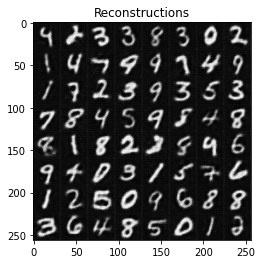

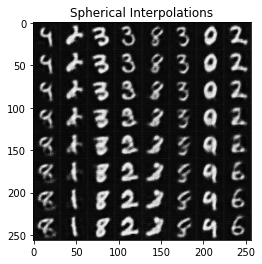

In [ ]:
for step in range(1001):
    # sample a batch of data
    x, t = next(train_iterator)
    x, t = x.to(device), t.to(device)

    # compute the gradients of the inner loss with respect to zeros (gradient origin)
    z = torch.zeros(batch_size, nz, 1, 1).to(device).requires_grad_()
    g = F(z)
    L_inner = ((g - x)**2).sum(1).mean()
    grad = torch.autograd.grad(L_inner, [z], create_graph=True, retain_graph=True)[0]
    z = (-grad)

    # now with z as our new latent points, optimise the data fitting loss
    g = F(z)
    L_outer = ((g - x)**2).sum(1).mean()
    optim.zero_grad()
    L_outer.backward()
    optim.step()

    if step % 100 == 0 and step > 0:
        print(f"Step: {step}   Loss: {L_outer.item():.3f}")

        # plot reconstructions and interpolations
        recons = torchvision.utils.make_grid(torch.clamp(g, 0, 1), padding=0, nrow=8)
        slerps = torchvision.utils.make_grid(torch.clamp(slerp_batch(F, z.data), 0, 1), padding=0, nrow=8)

        clear_output()
        plt.title('Reconstructions')
        plt.imshow(recons[0,:,:].reshape(256,256,1).repeat(1,1,3).cpu().data.numpy())
        plt.figure()
        plt.title('Spherical Interpolations')
        plt.imshow(slerps[0,:,:].reshape(256,256,1).repeat(1,1,3).cpu().data.numpy())
        plt.show()
        sleep(1)

**Comments:**

The gradient origin network loss is:

$$G_{\mathbf{x}} = \mathcal{L} ( \mathbf{x}, F(-\nabla_{\mathbf{z}_0} \mathcal{L}(\mathbf{x}, F(\mathbf{z}_0))) ),$$

where we first compute the gradients of the inner loss with respect to the zero vector $\mathbf{z}_0$:

$$\mathbf{z} = -\nabla_{\mathbf{z}_0} \mathcal{L}(\mathbf{x}, F(\mathbf{z}_0)).$$

```
z = torch.zeros(batch_size, nz, 1, 1).to(device).requires_grad_()
g = F(z)
L_inner = ((g - x)**2).sum(1).mean()
grad = torch.autograd.grad(L_inner, [z], create_graph=True, retain_graph=True)[0]
z = (-grad)
```

These gradients act as the latent space that we will call $\mathbf{z}$. We can optimise the outer loss:

$$G_{\mathbf{x}} = \mathcal{L}( \mathbf{x}, F(\mathbf{z} ))$$

```
g = F(z)
L_outer = ((g - x)**2).sum(1).mean()
optim.zero_grad()
L_outer.backward()
optim.step()
```